In [7]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

libpath = "simclr_impl"
sys.path.append(libpath)

In [8]:
from DataGeneratorSimCLR import DataGeneratorSimCLR as DataGenerator
from SimCLR import SimCLR

In [9]:
batch_size = 32
# Projection_head
num_layers_ph = 2
feat_dims_ph = [2048, 128]
num_of_unfrozen_layers = 1 #Note: with 1, all weights of the base_model are still frozen (last layer is max_pool)
save_path = 'models/trashnet'

In [10]:
# Img size
#size = 80

height_img = 128
width_img = 128

input_shape = (height_img, width_img, 3)

In [12]:
import numpy as np
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16 

from evaluate_features import get_features, linear_classifier, tSNE_vis

In [13]:
params_vgg16 = {'weights': "imagenet", 
                'include_top': False, 
                'input_shape': input_shape, 
                'pooling': None}

# Design model
base_model = VGG16(**params_vgg16)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [14]:
feat_dim = 2 * 2 * 512

In [18]:
if "DataGeneratorSimCLR" in sys.modules:
    del sys.modules["DataGeneratorSimCLR"]
    
if "SimCLR" in sys.modules:
    del sys.modules["SimCLR"]

from DataGeneratorSimCLR import DataGeneratorSimCLR as DataGenerator
from SimCLR import SimCLR

In [16]:
batch_size = 32
# Projection_head
num_layers_ph = 2
feat_dims_ph = [2048, 128]
num_of_unfrozen_layers = 1 #Note: with 1, all weights of the base_model are still frozen (last layer is max_pool)
save_path = 'models/trashnet'

In [17]:
SimCLR = SimCLR(
        base_model = base_model,
        input_shape = input_shape,
        batch_size = batch_size,
        feat_dim = feat_dim,
        feat_dims_ph = feat_dims_ph,
        num_of_unfrozen_layers = num_of_unfrozen_layers,
        save_path = save_path
    )

In [20]:
from tensorflow import keras

dataset = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture", 
                image_size = (128, 128), 
                #subset="training",
                #validation_split=0.2,
                batch_size = 1,
                seed = 1234,
                shuffle=True
                )

Found 39424 files belonging to 154 classes.


In [21]:
n_classes = len(dataset.class_names)
#n_samples = len(dataset.file_paths)
n_samples = len(dataset) * 1
n_batches = len(dataset)

print("n_classes = ", n_classes)
print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_classes =  154
n_samples =  39424
n_batches =  39424


In [22]:
#
#    80% (training) + 20% (test)
#
# we keep 80% of the dataset as training
n_training_batches = np.int(0.8 * n_batches)
dataset_training = dataset.take(n_training_batches)

# we keep 10% of the dataset as testing
n_testing_batches = n_batches - n_training_batches
dataset_testing = dataset.skip(n_training_batches).take(n_testing_batches)

print("n_training_batches = ", n_training_batches)
print("n_testing_batches = ", n_testing_batches)

n_training_batches =  31539
n_testing_batches =  7885


In [23]:
if "split_keras_dataset_to_xy" in sys.modules:
    del sys.modules["split_keras_dataset_to_xy"]

from split_keras_dataset_to_xy import split_keras_dataset_to_xy

In [24]:
X_train, y_train = split_keras_dataset_to_xy(dataset_training)

data_shape =  (128, 128, 3)
X.shape =  (31539, 128, 128, 3)
y.shape =  (31539,)


In [25]:
X_test, y_test = split_keras_dataset_to_xy(dataset_testing)

data_shape =  (128, 128, 3)
X.shape =  (7885, 128, 128, 3)
y.shape =  (7885,)


In [26]:
print(y_train[0])
print(dataset.class_names[y_train[0]])

147
Dz93


In [27]:
print(X_train[0].shape)

(128, 128, 3)


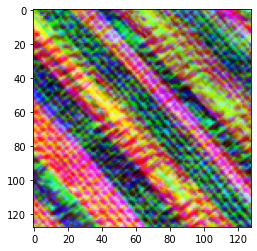

In [28]:
import matplotlib.pyplot as plt

plt.imshow(np.array(X_train[1], dtype = np.uint8))
plt.show()

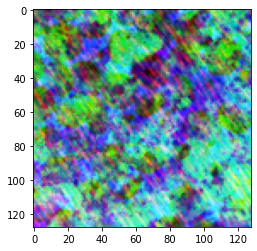

In [29]:
plt.imshow(np.array(X_test[1], dtype = np.uint8))
plt.show()

In [30]:
X_train.shape

(31539, 128, 128, 3)

In [ ]:
import numpy as np
import cv2 as cv

import tensorflow as tf
from keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.utils import data_utils

from SimCLR_data_util import *
import random


class MyDataGenerator(data_utils.Sequence):
    def __init__(
        self,
        X, y, #df,
        batch_size=16,
        subset="train",
        shuffle=True,
        info={},
        width=128, #80,
        height=128, #80,
        VGG=False,
    ):
        super().__init__()
        #self.df = df
        self.X = X
        self.y = y
        
        self.indexes = np.asarray(list(range(len(y))))
        self.batch_size = batch_size
        self.subset = subset
        self.shuffle = shuffle
        self.info = info
        self.width = width
        self.height = height
        self.VGG = VGG
        self.on_epoch_end()

    def __len__(self):
        #return int(np.ceil(len(self.df) / float(self.batch_size)))
        return int(np.ceil(len(self.y) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        X = np.empty(
            (2 * self.batch_size, 1, self.height, self.width, 3),
            dtype=np.float32,
        )

        indexes = self.indexes[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        
        #batch_data = self.df.iloc[indexes]
        batch_data_X = self.X[indexes]
        batch_data_y = self.y[indexes]
        
        # Add shuffle in order to avoid network recalling fixed order
        shuffle_a = np.arange(self.batch_size)
        shuffle_b = np.arange(self.batch_size)

        if self.subset == "train":
            random.shuffle(shuffle_a)
            random.shuffle(shuffle_b)
        if self.subset == "val":
            # Exclude randomness for evaluation
            random.seed(42)
            random.shuffle(shuffle_a)
            random.shuffle(shuffle_b)

        labels_ab_aa = np.zeros((self.batch_size, 2 * self.batch_size))
        labels_ba_bb = np.zeros((self.batch_size, 2 * self.batch_size))

        for i, row in enumerate(batch_data.iterrows()):
            filename = row[1]["filename"]
            self.info[index * self.batch_size + i] = filename
            img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)

            img = tf.convert_to_tensor(
                np.asarray((img / 255)).astype("float32")
            )

            img_T1 = preprocess_for_train(
                img,
                self.height,
                self.width,
                color_distort=True,
                crop=False,
                flip=False,
                blur=False,
            )
            img_T2 = preprocess_for_train(
                img,
                self.height,
                self.width,
                color_distort=True,
                crop=False,
                flip=False,
                blur=False,
            )

            if self.VGG:
                img_T1 = tf.dtypes.cast(img_T1 * 255, tf.int32)
                img_T2 = tf.dtypes.cast(img_T2 * 255, tf.int32)
                img_T1 = preprocess_input(np.asarray(img_T1))
                img_T2 = preprocess_input(np.asarray(img_T2))

            # T1-images between 0 -> batch_size - 1
            X[shuffle_a[i]] = img_T1
            # T2-images between batch_size -> 2*batch_size - 1
            X[self.batch_size + shuffle_b[i]] = img_T2

            # label ab
            labels_ab_aa[shuffle_a[i], shuffle_b[i]] = 1
            # label ba
            labels_ba_bb[shuffle_b[i], shuffle_a[i]] = 1

        y = tf.concat([labels_ab_aa, labels_ba_bb], 1)

        # [None] is used to silence warning
        # https://stackoverflow.com/questions/59317919/warningtensorflowsample-weight-modes-were-coerced-from-to
        return list(X), y, [None]


In [ ]:
params_generator = {'batch_size': batch_size,
                    'shuffle' : True,
                    'width':width_img,
                    'height': height_img,
                    'VGG': True
                   }

# Generators
data_train = DataGenerator(df_train.reset_index(drop=True), **params_generator)
data_val = DataGenerator(df_val.reset_index(drop=True), subset = "val", **params_generator) #val keeps the unity values on the same random places ~42
data_test = DataGenerator(df_test.reset_index(drop=True), subset = "test", **params_generator) #test keeps the unity values on the diagonal